In [ ]:
#pip install pm4py

In [1]:
#import data
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

#model 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding

# Modelling

In [4]:
##prefix data

train_prefix_trace_encoded = np.load("helpdesk_train_prefix.npy")
val_prefix_trace_encoded = np.load("helpdesk_val_prefix.npy")
test_prefix_trace_encoded = np.load("helpdesk_test_prefix.npy")

##probability data
train_dfg_probability = pd.read_csv("helpdesk_train_dfg_probability.csv")
val_dfg_probability = pd.read_csv("helpdesk_val_dfg_probability.csv")
test_dfg_probability = pd.read_csv("helpdesk_test_dfg_probability.csv")

#target
train_target_encoded = np.load("helpdesk_train_target.npy")
val_target_encoded = np.load("helpdesk_val_target.npy")
test_target_encoded = np.load("helpdesk_test_target.npy")

#encoder
label_encoder = joblib.load('helpdesk_label_encoder.joblib')

#original data
train_target = pd.read_csv("helpdesk_train_target_org.csv")
test_target = pd.read_csv("helpdesk_test_target_org.csv")

## Prefix Model

In [7]:
# Example input shape: (timesteps, features)
features = train_prefix_trace_encoded.shape[1]
sequence = train_prefix_trace_encoded.shape[2]
output = train_target_encoded.shape[1]
prefix_model = Sequential()

#LSTM Layers
prefix_model.add(LSTM(400, return_sequences=False, input_shape=(features, sequence)))

# Output layer (classification)
prefix_model.add(Dense(output, activation='softmax'))
prefix_model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
prefix_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 400)            │       667,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         6,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,616 (2.57 MB)

 Trainable params: 673,616 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 9. Train Model
history = prefix_model.fit(train_prefix_trace_encoded, train_target_encoded, epochs=100, batch_size=100, validation_data = (val_prefix_trace_encoded, val_target_encoded))

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - categorical_accuracy: 0.2001 - loss: 2.7302 - val_categorical_accuracy: 0.2018 - val_loss: 2.6294
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - categorical_accuracy: 0.2395 - loss: 2.5977 - val_categorical_accuracy: 0.1934 - val_loss: 2.5029
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - categorical_accuracy: 0.2383 - loss: 2.4630 - val_categorical_accuracy: 0.1899 - val_loss: 2.3262
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - categorical_accuracy: 0.2175 - loss: 2.2595 - val_categorical_accuracy: 0.1868 - val_loss: 2.0437
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - categorical_accuracy: 0.2094 - loss: 1.9814 - val_categorical_accuracy: 0.1868 - val_loss: 1.8336
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - categorical_accuracy: 0.2119 - loss: 1.8185 - val_categorical_accuracy: 0.1927 - val_loss: 1.7665
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - catego

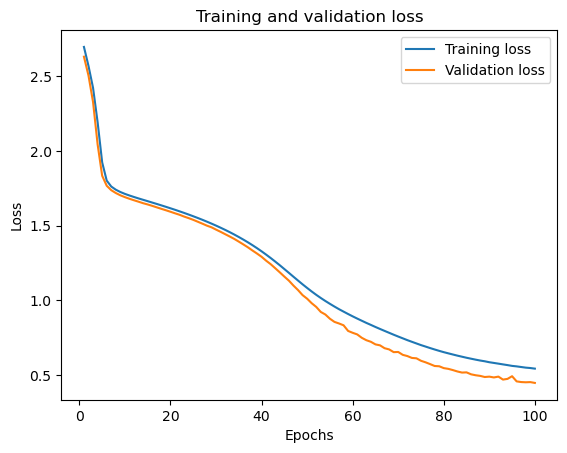

In [9]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Check Predictions

In [10]:
from predictions import single_input_prediction, multi_input_prediction

In [11]:
actual_label = train_target["activity"]
single_input_prediction(prefix_model, train_prefix_trace_encoded, label_encoder,actual_label)

512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step
train model recall 86.15779502536209%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)

In [12]:
actual_label = test_target["activity"]
test_predictions = single_input_prediction(prefix_model, test_prefix_trace_encoded, label_encoder,actual_label,"test")

206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
test model recall 82.3985408116735%


In [25]:
#save model
prefix_model.export("saved_model/prefix_model")

INFO:tensorflow:Assets written to: saved_model/prefix_model\assets


INFO:tensorflow:Assets written to: saved_model/prefix_model\assets


Saved artifact at 'saved_model/prefix_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 16), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  1848135320784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848135322128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848135321936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848135323472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1848135322320: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [14]:
#prefix_model.evaluate(train_target["activity"],test_target["activity"])
prefix_model.evaluate(test_prefix_trace_encoded,test_target_encoded)

206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - categorical_accuracy: 0.8194 - loss: 0.8481


[0.8298004865646362, 0.8239853978157043]

## DFG Model Only

In [15]:
from tensorflow.keras.layers import Dropout

dfg_model = Sequential()

#Layers
dfg_model.add(Dense(100,activation="relu", input_shape=(train_dfg_probability.shape[1],)))


# Output layer (classification)
dfg_model.add(Dense(train_target_encoded.shape[1], activation='softmax'))
dfg_model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
dfg_model.summary()

C:\Users\obami\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 100)            │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,616 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,316 (12.95 KB)

 Trainable params: 3,316 (12.95 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 9. Train Model
history = dfg_model.fit(train_dfg_probability, train_target_encoded, epochs=100, batch_size=100, validation_data = (val_dfg_probability, val_target_encoded))

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - categorical_accuracy: 0.1900 - loss: 2.5237 - val_categorical_accuracy: 0.3627 - val_loss: 2.1895
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.3450 - loss: 2.1543 - val_categorical_accuracy: 0.5481 - val_loss: 2.0209
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.5100 - loss: 2.0208 - val_categorical_accuracy: 0.5481 - val_loss: 1.9249
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.5028 - loss: 1.9357 - val_categorical_accuracy: 0.5481 - val_loss: 1.8562
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.5123 - loss: 1.8736 - val_categorical_accuracy: 0.5481 - val_loss: 1.7978
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.5531 - loss: 1.8206 - val_categorical_accuracy: 0.7359 - val_loss: 1.7461
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.704

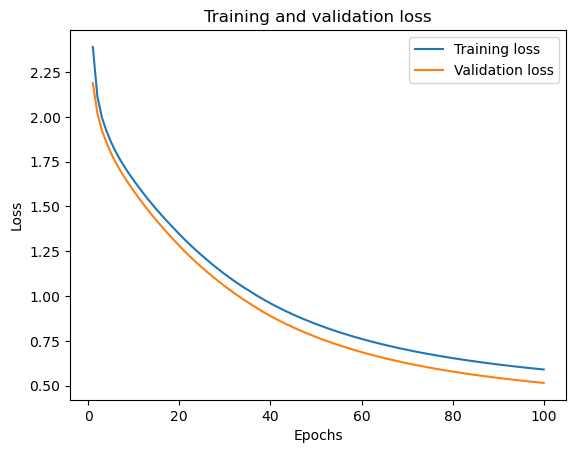

In [17]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
actual_label = train_target["activity"]
single_input_prediction(dfg_model, train_dfg_probability, label_encoder,actual_label)

512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
train model recall 85.4366558699505%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)

In [19]:
actual_label = test_target["activity"]
single_input_prediction(dfg_model, test_dfg_probability, label_encoder,actual_label,"test")

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
test model recall 84.16172670618634%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)

## Prefix DFG Model_1

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

#prefix input
prefix_features = train_prefix_trace_encoded.shape[1]
prefix_sequence = train_prefix_trace_encoded.shape[2]

prefix_input = Input(shape=(prefix_sequence,prefix_features),name="prefix")
prefix_model = LSTM(20, return_sequences=False, name="prefix_layer_1")(prefix_input)

# dfg input
dfg_features = train_dfg_probability.shape[1]

dfg_input = Input(shape=(dfg_features,),name="dfg")
dfg_model = Dense(10, activation="relu", name="dfg_layer_1")(dfg_input)


#Concatenate Layers
concatenated = Concatenate(name='Concatenated_Layer')([prefix_model, dfg_model])

# Output layer (classification)
output = train_target_encoded.shape[1]
output_layer = Dense(output,activation='softmax')(concatenated)

#Define model
prefix_dfg_model = Model(inputs=[prefix_input,dfg_input],outputs=output_layer)
prefix_dfg_model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
prefix_dfg_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ prefix (InputLayer) │ (None, 16, 16)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dfg (InputLayer)    │ (None, 16)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prefix_layer_1      │ (None, 20)        │      2,960 │ prefix[0][0]      │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dfg_layer_1 (Dense) │ (None, 10)        │        170 │ dfg[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenated_Layer  │ (None, 30)        │          0 │ prefix_layer_1[0… │
│ (Concatenate)       │                   │            │ dfg_layer_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        496 │ Concatenated_Lay… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,626 (14.16 KB)

 Trainable params: 3,626 (14.16 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = prefix_dfg_model.fit([train_prefix_trace_encoded,train_dfg_probability], train_target_encoded, epochs=100, batch_size=100, validation_data = ([val_prefix_trace_encoded,val_dfg_probability], val_target_encoded))

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - categorical_accuracy: 1.6720e-04 - loss: 3.2411 - val_categorical_accuracy: 6.9955e-04 - val_loss: 3.0862
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 8.4949e-04 - loss: 3.0063 - val_categorical_accuracy: 0.1773 - val_loss: 2.9569
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.1720 - loss: 2.9058 - val_categorical_accuracy: 0.1885 - val_loss: 2.8601
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.1836 - loss: 2.8041 - val_categorical_accuracy: 0.1906 - val_loss: 2.7773
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.1804 - loss: 2.7283 - val_categorical_accuracy: 0.1906 - val_loss: 2.7012
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.1781 - loss: 2.6576 - val_categorical_accuracy: 0.1906 - val_loss: 2.6272
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categori

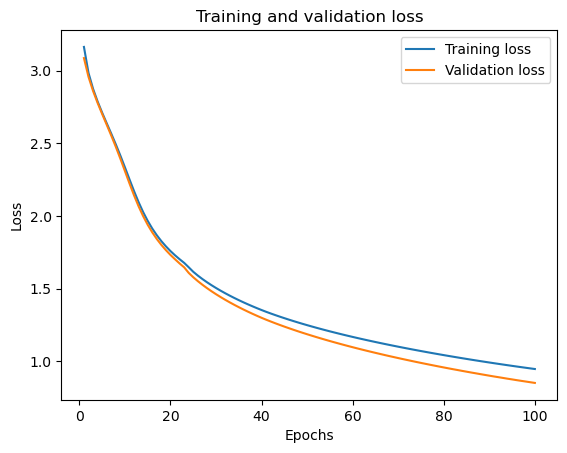

In [22]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
actual_label = train_target["activity"]
multi_input_prediction(prefix_dfg_model,train_prefix_trace_encoded, train_dfg_probability, label_encoder,actual_label)

512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
train model recall 85.11886573366742%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)

In [24]:
actual_label = test_target["activity"]
multi_input_prediction(prefix_dfg_model,test_prefix_trace_encoded, test_dfg_probability, label_encoder,actual_label)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
train model recall 83.66013071895425%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)

## Prefix_DFG Model_2

In [25]:
#prefix input
prefix_features = train_prefix_trace_encoded.shape[1]
prefix_sequence = train_prefix_trace_encoded.shape[2]

#prefix layer
prefix_input = Input(shape=(prefix_sequence,prefix_features),name="prefix")
prefix_model = LSTM(20, return_sequences=False, name="prefix_layer_1")(prefix_input)

#dfg input
dfg_features = train_dfg_probability.shape[1]
dfg_input = Input(shape=(dfg_features,),name="dfg")

# combine prefix with dfg input
combined_input = Concatenate(name="prefix_dfg_input")([prefix_model,dfg_input])
prefix_dfg_layer = Dense(20, activation="relu", name="dfg_layer_1")(combined_input)

# Output layer (classification)
output = train_target_encoded.shape[1]
output_layer = Dense(output,activation='softmax')(prefix_dfg_layer)

#Define model
prefix_dfg_model_2 = Model(inputs=[prefix_input,dfg_input],outputs=output_layer)
prefix_dfg_model_2.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
prefix_dfg_model_2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ prefix (InputLayer) │ (None, 16, 16)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prefix_layer_1      │ (None, 20)        │      2,960 │ prefix[0][0]      │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dfg (InputLayer)    │ (None, 16)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prefix_dfg_input    │ (None, 36)        │          0 │ prefix_layer_1[0… │
│ (Concatenate)       │                   │            │ dfg[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dfg_layer_1 (Dense) │ (None, 20)        │        740 │ prefix_dfg_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        336 │ dfg_layer_1[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,036 (15.77 KB)

 Trainable params: 4,036 (15.77 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = prefix_dfg_model_2.fit([train_prefix_trace_encoded,train_dfg_probability], train_target_encoded, epochs=200, batch_size=100, validation_data = ([val_prefix_trace_encoded,val_dfg_probability], val_target_encoded))

Epoch 1/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - categorical_accuracy: 0.3423 - loss: 2.5229 - val_categorical_accuracy: 0.3627 - val_loss: 2.3680
Epoch 2/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.3396 - loss: 2.3707 - val_categorical_accuracy: 0.3627 - val_loss: 2.2738
Epoch 3/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.3446 - loss: 2.2772 - val_categorical_accuracy: 0.3627 - val_loss: 2.2047
Epoch 4/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.3487 - loss: 2.1952 - val_categorical_accuracy: 0.3627 - val_loss: 2.1488
Epoch 5/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.3453 - loss: 2.1499 - val_categorical_accuracy: 0.3627 - val_loss: 2.1000
Epoch 6/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.3470 - loss: 2.1040 - val_categorical_accuracy: 0.3627 - val_loss: 2.0557
Epoch 7/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy

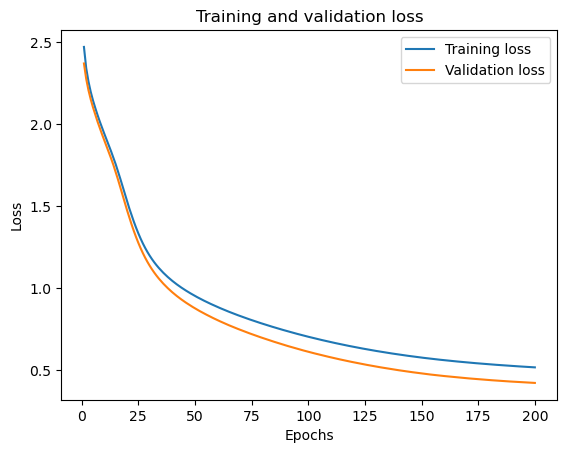

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
actual_label = train_target["activity"]
multi_input_prediction(prefix_dfg_model_2,train_prefix_trace_encoded, train_dfg_probability, label_encoder,actual_label)

512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
train model recall 85.22887001161156%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)

In [29]:
actual_label = test_target["activity"]
multi_input_prediction(prefix_dfg_model_2,test_prefix_trace_encoded, test_dfg_probability, label_encoder,actual_label)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
train model recall 82.93053655570756%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)

## Prefix_DFG Model_3

In [30]:
#dfg input layer
dfg_features = train_dfg_probability.shape[1]
dfg_input = Input(shape=(dfg_features,),name="dfg")
dfg_layer = Dense(100, activation="relu", name="dfg_layer")(dfg_input)

#prefix layer
prefix_features = train_prefix_trace_encoded.shape[1]
prefix_sequence = train_prefix_trace_encoded.shape[2]
prefix_input = Input(shape=(prefix_sequence,prefix_features),name="prefix")
prefix_layer = LSTM(20, return_sequences=False, name="prefix_dfg_layer")(prefix_input)

# combine dfg with prefix input
combined_input = Concatenate(name="prefix_dfg_input")([dfg_input,prefix_layer])

# Output layer (classification)
output = train_target_encoded.shape[1]
output_layer = Dense(output,activation='softmax')(combined_input)

#Define model
prefix_dfg_model_3 = Model(inputs=[dfg_input,prefix_input],outputs=output_layer)
prefix_dfg_model_3.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
prefix_dfg_model_3.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ prefix (InputLayer) │ (None, 16, 16)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dfg (InputLayer)    │ (None, 16)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prefix_dfg_layer    │ (None, 20)        │      2,960 │ prefix[0][0]      │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prefix_dfg_input    │ (None, 36)        │          0 │ dfg[0][0],        │
│ (Concatenate)       │                   │            │ prefix_dfg_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        592 │ prefix_dfg_input… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,552 (13.88 KB)

 Trainable params: 3,552 (13.88 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = prefix_dfg_model_3.fit([train_dfg_probability,train_prefix_trace_encoded], train_target_encoded, epochs=200, batch_size=100, validation_data = ([val_dfg_probability,val_prefix_trace_encoded], val_target_encoded))

Epoch 1/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - categorical_accuracy: 0.0203 - loss: 2.6018 - val_categorical_accuracy: 0.1868 - val_loss: 2.5205
Epoch 2/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.1774 - loss: 2.4689 - val_categorical_accuracy: 0.3627 - val_loss: 2.4324
Epoch 3/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - categorical_accuracy: 0.3357 - loss: 2.3933 - val_categorical_accuracy: 0.3631 - val_loss: 2.3652
Epoch 4/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.3327 - loss: 2.3448 - val_categorical_accuracy: 0.3648 - val_loss: 2.3080
Epoch 5/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.3392 - loss: 2.2851 - val_categorical_accuracy: 0.3648 - val_loss: 2.2567
Epoch 6/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.3423 - loss: 2.2450 - val_categorical_accuracy: 0.3648 - val_loss: 2.2086
Epoch 7/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy

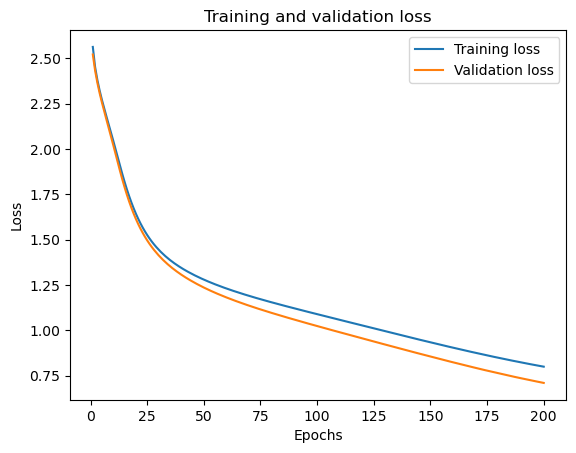

In [32]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
actual_label = train_target["activity"]
multi_input_prediction(prefix_dfg_model_3, train_dfg_probability,train_prefix_trace_encoded, label_encoder,actual_label)

512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
train model recall 85.20442461651287%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)

In [34]:
actual_label = test_target["activity"]
multi_input_prediction(prefix_dfg_model_3,test_dfg_probability, test_prefix_trace_encoded, label_encoder,actual_label)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
train model recall 82.86973704210367%


array(['assign seriousness', 'take in charge ticket', 'resolve ticket',
       ..., 'resolve ticket', 'closed', 'zos'], dtype=object)